# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git\

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from adni.load_data import load_data
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
from operator import add
from sklearn import datasets as ds
import seaborn
import sklearn
from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, svm, decomposition
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve ,auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from functools import reduce

## Data loading and cleaning

The data is loaded from the provided .csv file

In [3]:
# Data loading
data = load_data()
headers = data.columns.values.tolist()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 855
The number of columns: 268


## Data preprocessing

First the data is checked for missing data and samples or features with too many zeros

In [4]:
# check for missing data
data.isnull().sum().sum()

# Check for zeros
for column_name in data.columns:
    column = data[column_name]
    # Get the count of zeros in column
    count = (column == 0).sum()
# remove columns with more than 50% zeros
drop_cols = data.columns[(data == 0).sum() > 0.5*data.shape[1]]
data.drop(drop_cols, axis=1, inplace=True)
print(f'The number of samples after removing zeros: {len(data.index)}')
print(f'The number of columns after removing zeros: {len(data.columns)}')


The number of samples after removing zeros: 855
The number of columns after removing zeros: 261


The labels are extracted from the dataset

In [5]:
labels = data.label
col = "label"
features = data.loc[:, data.columns != col]
headers_features = features.columns.values.tolist()

# number of AD en CN
labels.value_counts()


AD    519
CN    336
Name: label, dtype: int64

The data is split in a training and testing dataset at random. Here, 80% of the original dataset is assigned to the training set and the remaining 20% is assigned to the testing set

In [6]:
train_features, test_features, train_labels, test_labels = model_selection.train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=1)
y_train = train_labels[:]
y_train[y_train == 0] = 'CN'
y_train[y_train == 1] = 'AD'
print(train_features.shape)
print(test_features.shape)


(684, 260)
(171, 260)


## Feature selection
The variance in the dataset was analysed using ANOVA. Features were selected using univariance analysis.

C:\Users\mark_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [208 211 213] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\mark_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\mark_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [208 211 213] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\mark_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


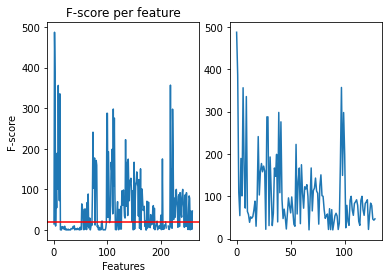

In [7]:
anova = sklearn.feature_selection.f_classif(train_features, train_labels)
f1 = anova[0]
p = anova[1]
x = range(260)
f2 = f1[f1 > 20]
number_of_features = len(f2)
x2 = range(number_of_features)

plt.subplot(1, 2, 1)
plt.plot(x, f1)
plt.axhline(y=20, color='r', linestyle='-')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.title('F-score per feature')
plt.subplot(1, 2, 2)
plt.plot(x2, f2)

# select the best features
fs = SelectKBest(f_classif, k=number_of_features)
fs.fit(train_features, train_labels)
selected_features_train = fs.transform(train_features)

# scaling the data
scaled_features_train = MinMaxScaler().fit_transform(selected_features_train)


Features are scaled using a Min Max Scaler

In [8]:
selected_features_test = fs.transform(test_features)
scaled_features_test = MinMaxScaler().fit_transform(selected_features_test)


## Principal Component Analysis

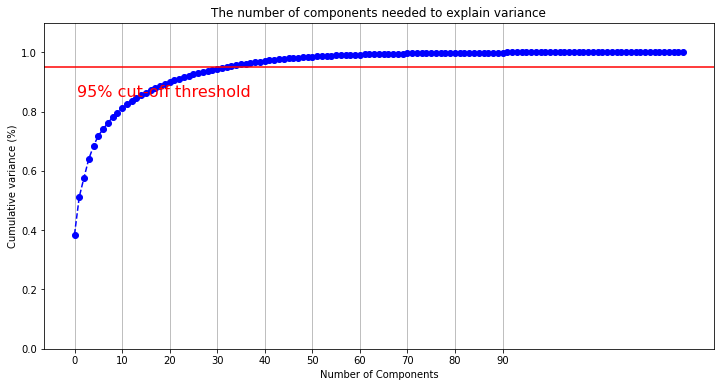

In [9]:
pca = PCA().fit(scaled_features_train)

# matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()
xi = np.arange(0, number_of_features, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=10))  # change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Define how many components will be used
pca = decomposition.PCA(n_components=30)
pca.fit(scaled_features_train)
pca_features_train = pca.transform(scaled_features_train)


In [10]:
#pca for test data 
pca_features_test = pca.transform(scaled_features_test)


## K-Nearest Neighbour Classifier

The optimal N=25
The accuracy of the best k-Nearest Neighbour is 0.8070175438596491


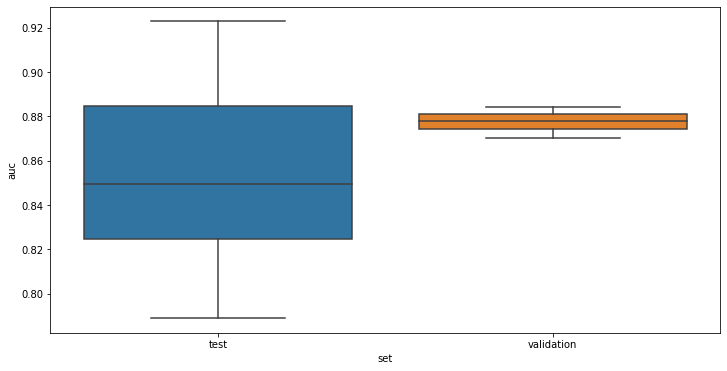

In [11]:
# Create a 10 fold stratified CV iterator
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_10fold.split(pca_features_train, train_labels):
    # Split the data properly
    X_validation = pca_features_train[validation_index]
    y_validation = train_labels[validation_index]

    X_test = pca_features_train[test_index]
    y_test = train_labels[test_index]

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    parameters = {"n_neighbors": list(range(1, 30, 1))}
    knn = neighbors.KNeighborsClassifier()
    grid_search = model_selection.GridSearchCV(knn, parameters,
                                               cv=cv_10fold,
                                               scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)

    # Get resulting classifier
    clf = grid_search.best_estimator_
    best_n_neighbors.append(clf.n_neighbors)

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })

    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]

    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })

# Create results dataframe and plot it
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

clf_knn = neighbors.KNeighborsClassifier(n_neighbors=optimal_n)
clf_knn.fit(pca_features_train, train_labels)
best_score = clf_knn.score(pca_features_train, train_labels)
print(f"The accuracy of the best k-Nearest Neighbour is {best_score}")


## Random Forest Classifier

In [12]:
# Create a baseline random forest classifier
random_forest = BaggingClassifier(DecisionTreeClassifier(random_state=1))
random_forest.fit(train_features, train_labels)

y_pred = random_forest.predict(train_features)
score = np.mean(cross_val_score(random_forest, train_features, train_labels, cv=10))
print(f"The accuracy of the baseline random forest classifier is {score}")


The accuracy of the baseline random forest classifier is 0.7878303495311167


A grid search is performed to find the best hyperparameters for the random forest

In [13]:
# Create the variables for the grid search
# Number of trees in random forest
n_estimators = [5, 10, 15, 25]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8, 10, 12]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
grid = {'n_estimators': n_estimators,
        'base_estimator__max_features': max_features,
        'base_estimator__max_depth': max_depth,           
        'base_estimator__min_samples_leaf': min_samples_leaf,
        'base_estimator__min_samples_split': min_samples_split,
        'bootstrap': bootstrap}


rf_grid = model_selection.GridSearchCV(estimator=random_forest,
                                       param_grid=grid,
                                       cv=5, verbose=2, n_jobs=-1)
rf_grid.fit(pca_features_train, train_labels)

best_max_features = rf_grid.best_params_['base_estimator__max_features']
best_min_samples_leaf = rf_grid.best_params_['base_estimator__min_samples_leaf']
best_min_samples_split = rf_grid.best_params_['base_estimator__min_samples_split']
best_n_estimators = rf_grid.best_params_['n_estimators']
best_grid = rf_grid.best_estimator_
best_param_rf = rf_grid.best_params_
predictions = rf_grid.predict(pca_features_train)
score = np.mean(cross_val_score(RandomForestClassifier(max_features=best_max_features,
                                                       min_samples_leaf=best_min_samples_leaf,
                                                       min_samples_split=best_min_samples_split,
                                                       n_estimators=best_n_estimators, bootstrap=True),
                                                       pca_features_train, train_labels, cv=10))

print(f"The accuracy of the optimized random forest classifier is {score}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
The accuracy of the optimized random forest classifier is 0.8069266837169652


## Support Vector Machine

In [14]:
# SVM classifier

# Create lists of datasets to loop over
X = pca_features_train
Y = train_labels

# grid search
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [1, 3, 5],
              'kernel': ['poly', 'rbf', 'linear', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X, Y)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END C=0.1, degree=1, gamma=10, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=10, kernel=poly;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=10, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=10, kernel=rbf;, score=0.606 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=10, kernel=rbf;, score=0.606 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=10, kernel=rbf;, score=0.606 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=10, kernel=rbf;, score=0.610 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [1, 3, 5],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly', 'rbf', 'linear', 'sigmoid']},
             verbose=3)

In [15]:
C_best = grid.best_params_['C']
degree_best = grid.best_params_['degree']
gamma_best = grid.best_params_['gamma']
kernel_best = grid.best_params_['kernel']

# SVM classfier na optimale bepaling
Xs = pca_features_train
Ys = train_labels

cv = KFold(n_splits=5, random_state=1, shuffle=True)
clf = SVC(kernel=kernel_best, C=C_best, gamma=gamma_best, degree=degree_best, probability=True)
clf.fit(Xs, Ys)
y_pred = clf.predict(X)
score = np.mean(cross_val_score(clf, X, Y, scoring='accuracy', cv=cv, n_jobs=-1))
print(f"The accuracy of the Support Vector Machine is: {score}")

The accuracy of the Support Vector Machine is: 0.8216294547015887


## Voting Classifier

In [16]:
# Create a voting classifier using the optimal hyperparameters for the KNN, SVM and RF
voting_classifier = VotingClassifier(estimators=[
                                                 ('KNN', KNeighborsClassifier(n_neighbors=optimal_n)),
                                                 ('SVM', SVC(kernel=kernel_best, C=C_best,
                                                  gamma=gamma_best, degree=degree_best, probability=True)),
                                                 ('rf', RandomForestClassifier(max_features=best_max_features,
                                                  min_samples_leaf=best_min_samples_leaf,
                                                  min_samples_split=best_min_samples_split,
                                                  n_estimators=best_n_estimators, bootstrap=True))], voting='soft')
voting_classifier.fit(pca_features_train, train_labels)
scores = cross_val_score(voting_classifier, pca_features_train, train_labels, cv=10, n_jobs=-1, error_score='raise')

print(f"The accuracy of the Voting classifier is: {np.mean(scores)}")


The accuracy of the Voting classifier is: 0.8098678601875532


## Evaluation using the test data

### Evaluation of the kNN

In [17]:
# Apply the kNN on the test data
knn_predict = clf_knn.predict(pca_features_test)

# Create a confusion matrix
knn_con_mat = confusion_matrix(test_labels, knn_predict)
print(knn_con_mat)

knn_sens = knn_con_mat[0, 0]/(knn_con_mat[0, 0]+knn_con_mat[0, 1])
knn_spec = knn_con_mat[1, 1]/(knn_con_mat[1, 0]+knn_con_mat[1, 1])

# Create a classification report
print(classification_report(test_labels, knn_predict))


[[87 17]
 [15 52]]
              precision    recall  f1-score   support

          AD       0.85      0.84      0.84       104
          CN       0.75      0.78      0.76        67

    accuracy                           0.81       171
   macro avg       0.80      0.81      0.80       171
weighted avg       0.81      0.81      0.81       171



### Evaluation of the Random Forest

In [18]:
# Apply the random forest on the test data
rf_predict = rf_grid.predict(pca_features_test)

# Create a confusion matrix
rf_con_mat = confusion_matrix(test_labels, rf_predict)
print(rf_con_mat)

rf_sens = rf_con_mat[0, 0]/(rf_con_mat[0, 0]+rf_con_mat[0, 1])
rf_spec = rf_con_mat[1, 1]/(rf_con_mat[1, 0]+rf_con_mat[1, 1])

# Create a classification report
print(classification_report(test_labels, rf_predict))


[[86 18]
 [19 48]]
              precision    recall  f1-score   support

          AD       0.82      0.83      0.82       104
          CN       0.73      0.72      0.72        67

    accuracy                           0.78       171
   macro avg       0.77      0.77      0.77       171
weighted avg       0.78      0.78      0.78       171



### Evaluation of SVM

In [19]:
# Apply SVM on test data
svm_predict = clf.predict(pca_features_test)

# Create a confusion matrix
svm_con_mat = confusion_matrix(test_labels, svm_predict)
print(svm_con_mat)

# Sensitivity and specificity
svm_sens = svm_con_mat[0, 0]/(svm_con_mat[0, 0]+svm_con_mat[0, 1])
svm_spec = svm_con_mat[1, 1]/(svm_con_mat[1, 0]+svm_con_mat[1, 1])

# Create a classification report
print(classification_report(test_labels, svm_predict))


[[87 17]
 [19 48]]
              precision    recall  f1-score   support

          AD       0.82      0.84      0.83       104
          CN       0.74      0.72      0.73        67

    accuracy                           0.79       171
   macro avg       0.78      0.78      0.78       171
weighted avg       0.79      0.79      0.79       171



### Evaluation of the Voting Classifier

In [20]:
# Apply the voting classifier on the test data
voting_predict = voting_classifier.predict(pca_features_test)

# Create a confusion matrix
voting_con_mat = confusion_matrix(test_labels, voting_predict)
print(voting_con_mat)

# Sensitivity and specificity
voting_sens = voting_con_mat[0, 0]/(voting_con_mat[0, 0]+voting_con_mat[0, 1])
voting_spec = voting_con_mat[1, 1]/(voting_con_mat[1, 0]+voting_con_mat[1, 1])

# Create a classification report
print(classification_report(test_labels, voting_predict))


[[87 17]
 [19 48]]
              precision    recall  f1-score   support

          AD       0.82      0.84      0.83       104
          CN       0.74      0.72      0.73        67

    accuracy                           0.79       171
   macro avg       0.78      0.78      0.78       171
weighted avg       0.79      0.79      0.79       171



## Create ROC curves

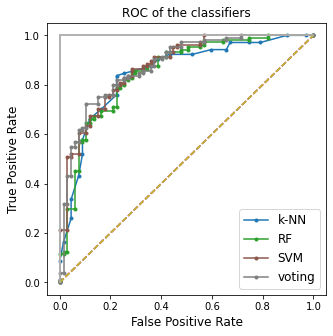

In [21]:
# Create ROC curves 

# Binary data
label_names = list(test_labels)
test_labels[test_labels == 'AD'] = 1
test_labels[test_labels == 'CN'] = 0
knn_predict[knn_predict == 'AD'] = 1
knn_predict[knn_predict == 'CN'] = 0
rf_predict[rf_predict == 'AD'] = 1
rf_predict[rf_predict == 'CN'] = 0
svm_predict[svm_predict == 'AD'] = 1
svm_predict[svm_predict == 'CN'] = 0
voting_predict[voting_predict == 'AD'] = 1
voting_predict[voting_predict == 'CN'] = 0
test_labels = test_labels.astype(int)
knn_predict = knn_predict.astype(int)
rf_predict = rf_predict.astype(int)
svm_predict = svm_predict.astype(int)
voting_predict = voting_predict.astype(int)

# k-NN
knn_probs = clf_knn.predict_proba(pca_features_test)
knn_probs = knn_probs[:, 1]
knn_probs = 1 - knn_probs
knn_auc = roc_auc_score(test_labels, knn_probs)
fpr_knn, tpr_knn, _ = roc_curve(test_labels, knn_probs)

# RF
rf_probs = rf_grid.predict_proba(pca_features_test)
rf_probs = rf_probs[:, 1]
rf_probs = 1 - rf_probs
rf_auc = roc_auc_score(test_labels, rf_probs)
fpr_rf, tpr_rf, _ = roc_curve(test_labels, rf_probs)

# SVM
svm_probs = clf.predict_proba(pca_features_test)
svm_probs = svm_probs[:, 1]
svm_probs = 1 - svm_probs
svm_auc = roc_auc_score(test_labels, svm_probs)
fpr_svm, tpr_svm, _ = roc_curve(test_labels, svm_probs)

# voting
voting_probs = voting_classifier.predict_proba(pca_features_test)
voting_probs = voting_probs[:, 1]
voting_probs = 1 - voting_probs
voting_auc = roc_auc_score(test_labels, voting_probs)
fpr_voting, tpr_voting, _ = roc_curve(test_labels, voting_probs)

# Plot ROC curves
plt.subplots(1, figsize=(5, 5))
plt.title(f"ROC of the classifiers", fontsize=12)
plt.plot(fpr_knn, tpr_knn, marker='.', label='k-NN')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.plot(fpr_rf, tpr_rf, marker='.', label='RF')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.plot(fpr_svm, tpr_svm, marker='.', label='SVM')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.plot(fpr_voting, tpr_voting, marker='.', label='voting')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=12)